# Homework 4

### Part 1: Tokenization

In [1]:
import string

In [2]:
# Define a function to transform the text
def text_transformer(txt):
    
    # Remove all non-ASCII characters
    txt = txt.encode('ascii',errors='ignore').decode()
    
    # Remove punctuation characters
    remove_punctuation = str.maketrans("", "", string.punctuation)
    txt = txt.translate(remove_punctuation)
    
    # Convert text to lowercase
    txt = txt.lower()
    
    return txt


In [3]:
# Create dictionary with all tokens
wdict = {}
with open('Life_On_The_Mississippi.txt', 'r') as L:
    line = text_transformer(L.readline())
    nlines = 1
    while line:

        words = line.split()
        for word in words:
            if wdict.get(word) is not None:
                wdict[word] += 1
            else:
                wdict[word] = 1
        line = text_transformer(L.readline())
        nlines += 1

# Sort dictionary according to token frequency
wdict = dict(sorted(wdict.items(), key=lambda x:x[1], reverse=True))

# Print top 100 words
print("Top 100 words in the book:")
nitem = 0 ; maxitems = 100
for word in wdict.keys():
    nitem += 1
    if nitem < maxitems:
        print(word + ", ", end="")
    else:
        print(word + ".")
    if nitem == maxitems: break
    
# Convert occurrences into frequencies
n_words = sum(wdict.values())
cum_freq = 0
for word in wdict:
    cum_freq += wdict[word] / n_words
    wdict[word] = cum_freq
    
# Find out how many words represent 90% of the vocabulary
n_90 = 1
for word in wdict:
    if wdict[word] >= 0.9: break
    n_90 += 1
print('\n' + f'The total book contains {n_words} words, but only {n_90} words make up 90% of all words.')

Top 100 words in the book:
the, and, of, a, to, in, it, i, was, that, he, is, for, with, you, his, had, but, on, as, this, they, at, not, all, by, one, there, were, be, my, or, from, have, out, so, up, him, we, me, when, would, which, river, an, them, no, then, said, are, if, their, now, about, time, been, down, its, could, has, will, into, what, her, two, do, other, some, man, new, any, got, these, she, who, more, water, did, before, over, way, hundred, upon, here, after, day, than, well, through, get, old, every, can, boat, went, never, good, years, see, know.

The total book contains 147420 words, but only 3732 words make up 90% of all words.


### Part 2: Embedding

In [4]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [100, 60]

# Load BERT.
model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking')
# Set the model to eval mode.
model.eval()
# This notebook assumes CPU execution. If you want to use GPUs, put the model on cuda and modify subsequent code blocks.
#model.to('cuda')
# Load tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

# Save the BERT vocabulary to a file -- by default it will name this file "vocab.txt".
tokenizer.save_vocabulary(save_directory='.')

print("The vocabulary size is: ", model.config.vocab_size) # Size of the vocabulary

2024-03-20 14:13:29.021816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.

The vocabulary size is:  30522


In [5]:
# Get BERT's vocabulary embeddings.
wordembs = model.get_input_embeddings()

# Convert the vocabulary embeddings to numpy.
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()
print(bertwordembs.shape)

(30522, 1024)


In [6]:
# Read in the vocabulary
filename = "vocab.txt"
with open(filename,'r') as f:
    bertwords = np.array([])
    for line in f:
        bertwords = np.append(bertwords, line.rstrip())

# Determine vocabulary to use for t-SNE/visualization. The indices are hard-coded based partially on inspection:
bert_char_indices_to_use = np.arange(999, 1063, 1)
bert_voc_indices_to_plot = np.append(bert_char_indices_to_use, np.arange(1996, 5932, 1))
bert_voc_indices_to_use = np.append(bert_char_indices_to_use, np.arange(1996, 11932, 1))

bert_voc_indices_to_use_tensor = torch.LongTensor(bert_voc_indices_to_use)
bert_word_embs_to_use = wordembs(bert_voc_indices_to_use_tensor).detach().numpy()
bert_words_to_plot = bertwords[bert_voc_indices_to_plot]


print(len(bert_voc_indices_to_plot))
print(len(bert_voc_indices_to_use))

4000
10000


In [7]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2500)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.267747
[t-SNE] Computed conditional probabilities in 0.196s
[t-SNE] Iteration 50: error = 97.8563843, gradient norm = 0.0068959 (50 iterations in 0.762s)
[t-SNE] It

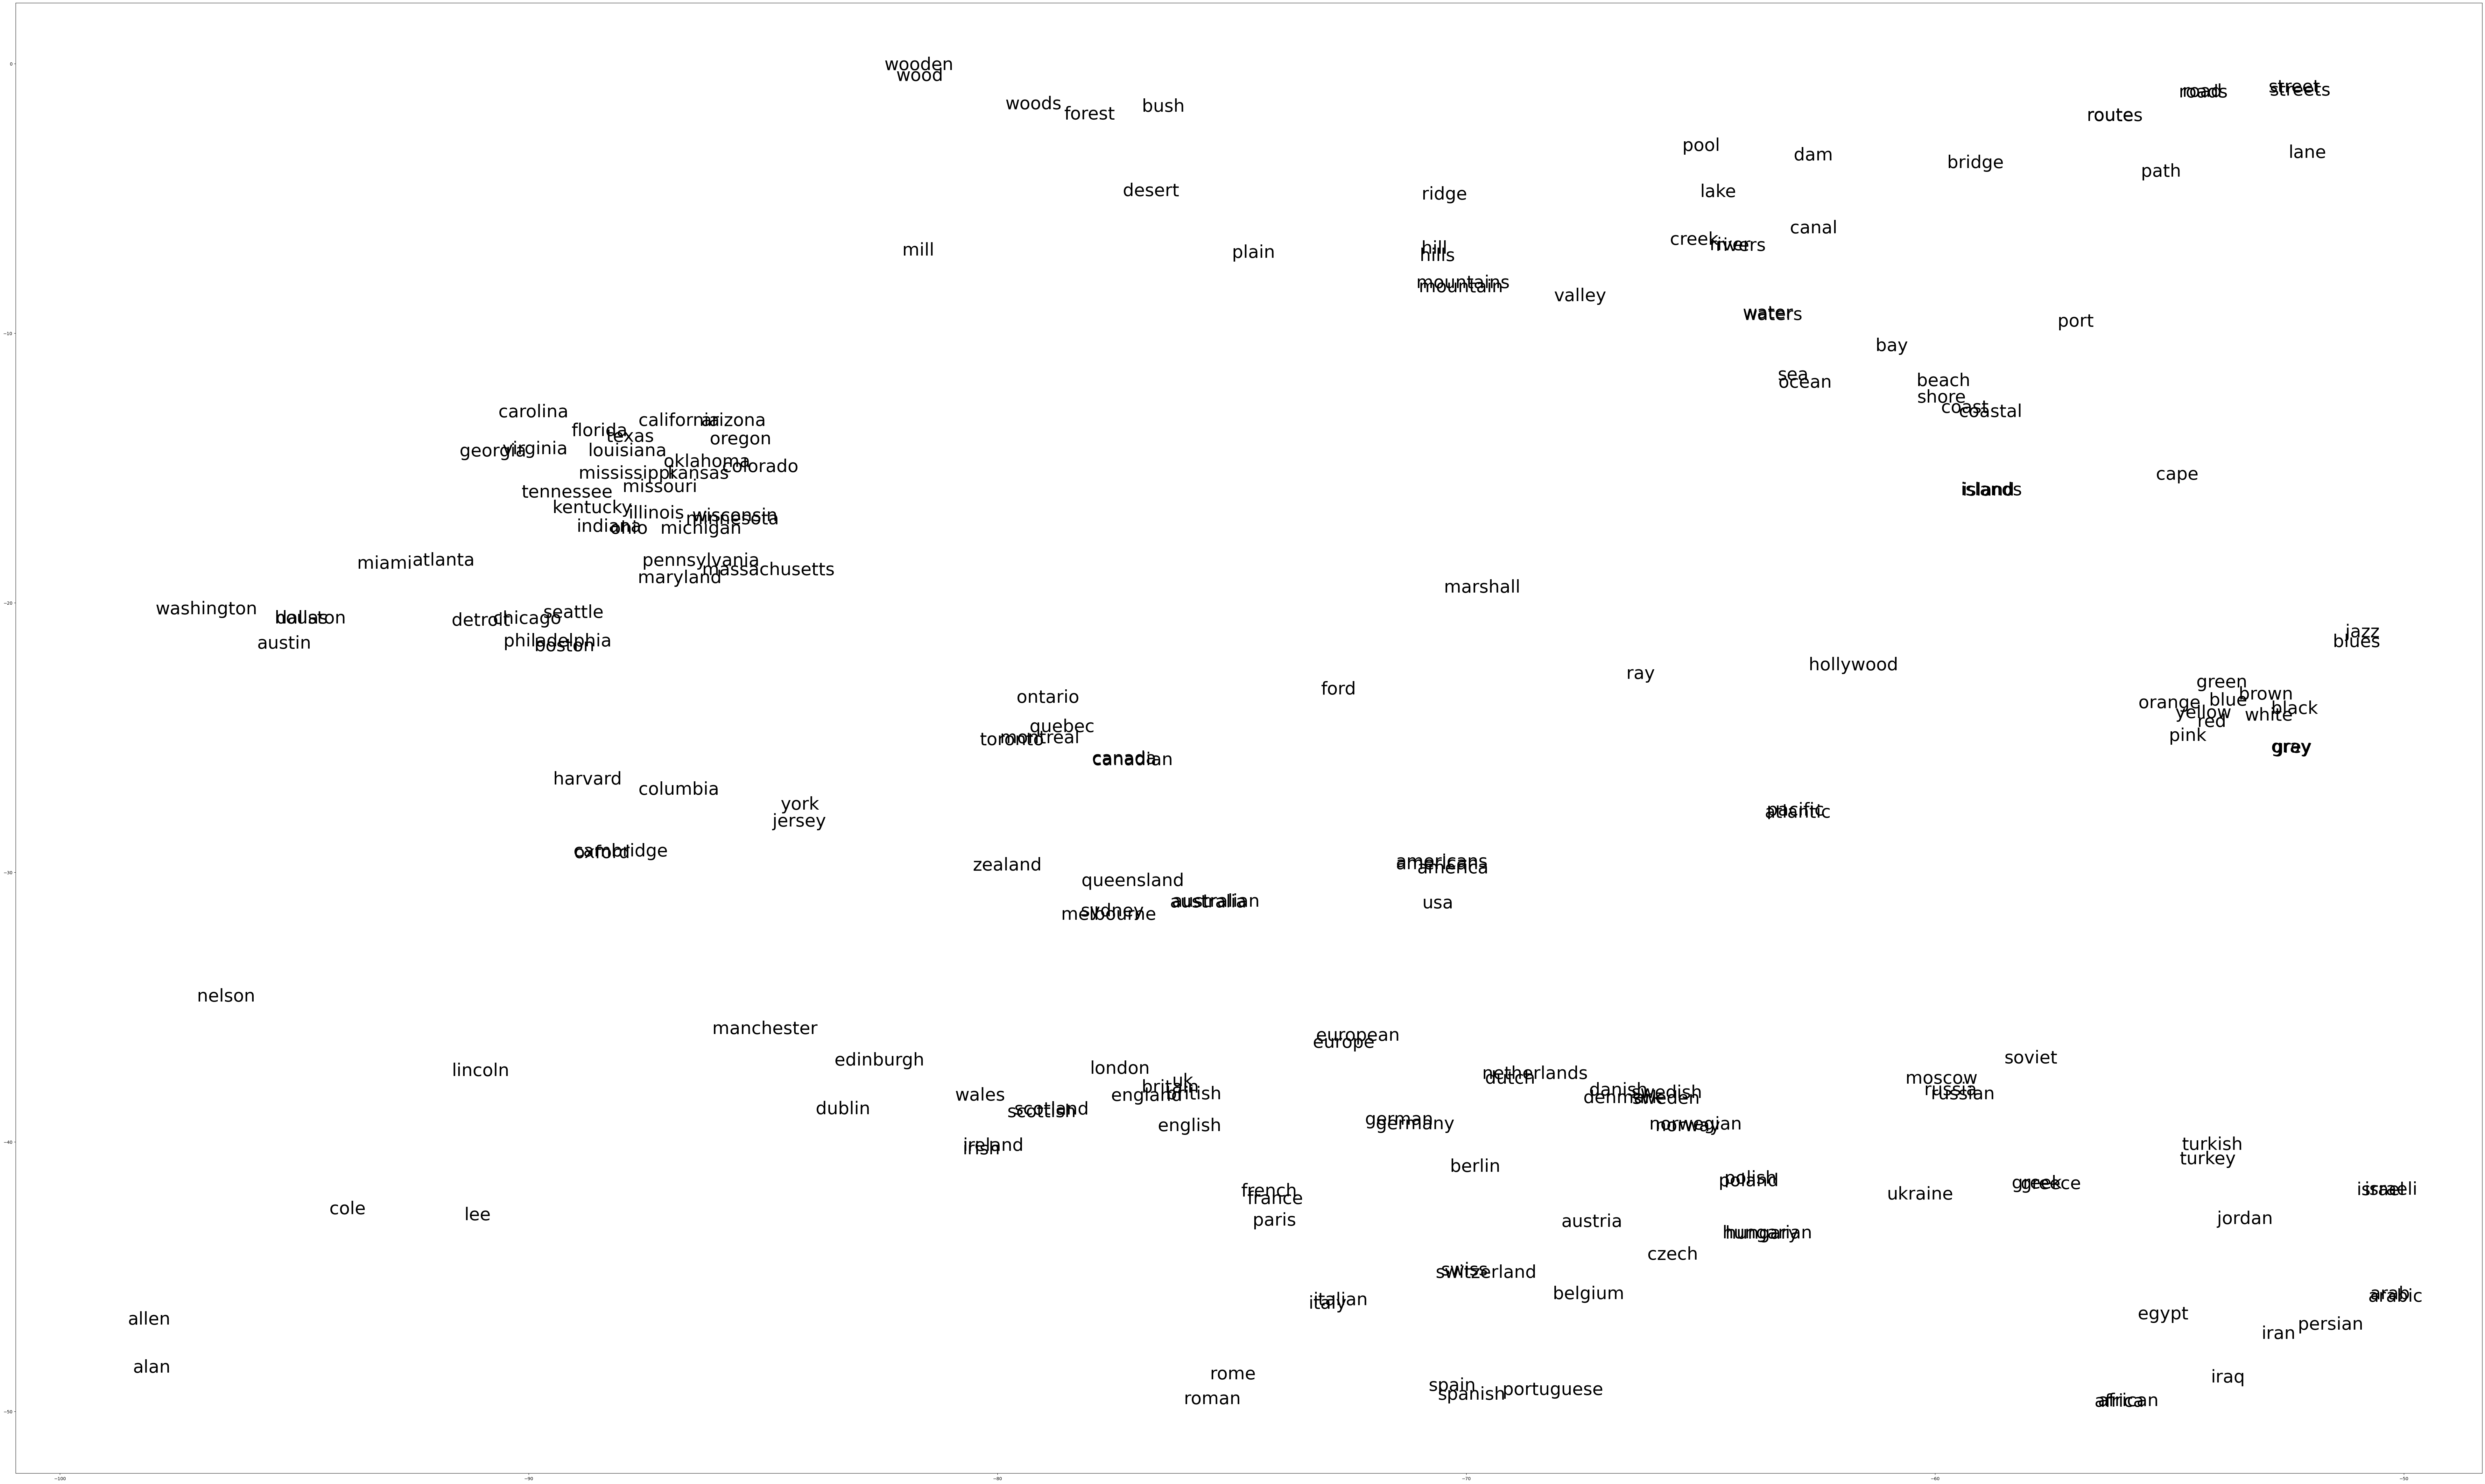

In [26]:
# Plot the transformed BERT vocabulary embeddings:
fig = plt.figure()
texts = list()

# Only show selected part of the words
x_min = -100
x_max = -50
y_min = -50
y_max = 0

for i, txt in enumerate(bert_words_to_plot):
    if bert_word_embs_to_use_tsne[i,0] >= x_min and bert_word_embs_to_use_tsne[i,0] <= x_max:
        if bert_word_embs_to_use_tsne[i,1] >= y_min and bert_word_embs_to_use_tsne[i,1] <= y_max:
            plt.scatter(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], s=0)
            currtext = plt.text(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], txt, family='sans-serif', fontsize=40)
            texts.append(currtext)
    
plt.show()

The tokens representing coutnries and languages are close together, and european countries as well as U.S. states form sub-clusters within this region.